In [11]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import xarray
from tqdm.notebook import tqdm
import seaborn as sns
%matplotlib inline
from sklearn.impute import KNNImputer
# Modelagem do RF
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# Análise dos dados gerados
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve


### Adiquirindo os Dados

In [12]:
df = pd.read_csv('E:/ML_RS/Qgis/Passo_feio/df_pf_gam_mdt_lsat.csv',
                 header=0, 
                 usecols='fid,lon,lat,TC,Kperc,eU,eTh,U_Th,U_K,Th_K,MDT,COD_UNI_ES,SIGLA_UNID,LS9_B6_SWIR,LS9_B5_NIR,LS9_B4_Red,LS9_B3_Green,LS9_B2_Blue,LS9_B7_SWIR2,LS9_RGB_Falsacor_1,LS9_RGB_Falsacor_2,LS9_RGB_Falsacor_3'.split(','),
                 low_memory=False)

# Conversão para GeoDataFrame
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:31982")  # SIRGAS 2000 / UTM zone 22S

# Mantenha 'df' também para compatibilidade (opcional)
df = gdf  

In [13]:
column_names = "fid lon lat TC Kperc eU eTh U_Th U_K Th_K MDT COD_UNI_ES SIGLA_UNID LS9_B6_SWIR LS9_B5_NIR LS9_B4_Red LS9_B3_Green LS9_B2_Blue LS9_B7_SWIR2 LS9_RGB_Falsacor_1 LS9_RGB_Falsacor_2 LS9_RGB_Falsacor_3".split(' ')
column_names


['fid',
 'lon',
 'lat',
 'TC',
 'Kperc',
 'eU',
 'eTh',
 'U_Th',
 'U_K',
 'Th_K',
 'MDT',
 'COD_UNI_ES',
 'SIGLA_UNID',
 'LS9_B6_SWIR',
 'LS9_B5_NIR',
 'LS9_B4_Red',
 'LS9_B3_Green',
 'LS9_B2_Blue',
 'LS9_B7_SWIR2',
 'LS9_RGB_Falsacor_1',
 'LS9_RGB_Falsacor_2',
 'LS9_RGB_Falsacor_3']

### Visualização dos Dados

In [14]:
df.describe()

,fid,lon,lat,TC,Kperc,eU,eTh,U_Th,U_K,Th_K,...,COD_UNI_ES,LS9_B6_SWIR,LS9_B5_NIR,LS9_B4_Red,LS9_B3_Green,LS9_B2_Blue,LS9_B7_SWIR2,LS9_RGB_Falsacor_1,LS9_RGB_Falsacor_2,LS9_RGB_Falsacor_3
count,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,...,6237.000000,6253.000000,6253.000000,6253.000000,6253.000000,6253.000000,6253.000000,6455.000000,6455.000000,6455.000000
mean,3240.500000,-53.564996,-30.635005,0.500039,0.494855,0.501498,0.489132,5.329372,7.485620,12.198262,...,2217.307520,10252.115625,17495.964017,8599.580681,8984.144091,8111.893171,10252.115625,63.807591,87.724555,39.584198
std,1870.759204,0.037876,0.079246,0.289611,0.288567,0.286502,0.288364,98.575916,150.306415,589.482663,...,1591.257019,1219.420879,2733.728247,595.341097,599.665233,310.157696,1219.420879,15.944361,19.107456,9.962013
min,1.000000,-53.629990,-30.769983,0.000044,0.000004,0.000505,0.000029,0.000717,0.000718,0.000067,...,135.000000,7397.000000,7687.000000,7315.000000,7477.000000,7334.000000,7397.000000,0.000000,0.000000,0.000000
25%,1620.750000,-53.597493,-30.702494,0.248856,0.244507,0.255996,0.237625,0.510615,0.517667,0.493398,...,152.000000,9328.000000,15758.000000,8148.000000,8513.000000,7885.000000,9328.000000,58.500000,84.000000,36.000000
50%,3240.500000,-53.564996,-30.635005,0.499756,0.492584,0.506608,0.476460,1.027505,1.010362,0.995360,...,2711.000000,10181.000000,17556.000000,8525.000000,8949.000000,8096.000000,10181.000000,66.000000,91.000000,41.000000
75%,4860.250000,-53.532499,-30.567516,0.750780,0.744987,0.746949,0.738907,2.101909,2.038083,1.985643,...,3661.000000,11062.000000,19270.000000,8970.000000,9421.000000,8308.000000,11062.000000,74.000000,98.000000,45.000000
max,6480.000000,-53.500002,-30.500027,0.999761,0.999953,0.999603,0.999844,7550.956899,9793.230459,47292.650373,...,7252.000000,15615.000000,27315.000000,12372.000000,11667.000000,10137.000000,15615.000000,98.000000,125.000000,65.000000


### Organização e visualização dos dados

In [15]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6480 entries, 0 to 6479
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   fid                 6480 non-null   int64   
 1   lon                 6480 non-null   float64 
 2   lat                 6480 non-null   float64 
 3   TC                  6480 non-null   float64 
 4   Kperc               6480 non-null   float64 
 5   eU                  6480 non-null   float64 
 6   eTh                 6480 non-null   float64 
 7   U_Th                6480 non-null   float64 
 8   U_K                 6480 non-null   float64 
 9   Th_K                6480 non-null   float64 
 10  MDT                 6195 non-null   float64 
 11  COD_UNI_ES          6237 non-null   float64 
 12  SIGLA_UNID          6237 non-null   object  
 13  LS9_B6_SWIR         6253 non-null   float64 
 14  LS9_B5_NIR          6253 non-null   float64 
 15  LS9_B4_Red          6253 non-n

### Limpando os dados

In [16]:
# 1. Separar colunas por tipo e significado (mantendo sua estrutura original)
geo_cols = ['lon', 'lat', 'MDT']
radiometric_cols = ['TC', 'Kperc', 'eU', 'eTh', 'U_Th', 'U_K', 'Th_K']
spectral_cols = [c for c in df.columns if 'LS9_' in c]
categorical_cols = ['SIGLA_UNID']
id_cols = ['fid', 'COD_UNI_ES']

# 2. Tratamento para dados categóricos - REMOVER NAs em vez de criar UNKNOWN
print("Distribuição original de SIGLA_UNID:\n", df['SIGLA_UNID'].value_counts())
print(f"\nLinhas com SIGLA_UNID faltante: {df['SIGLA_UNID'].isna().sum()}")

# Remover linhas onde SIGLA_UNID é NA 
df = df.dropna(subset=['SIGLA_UNID']).copy()
print("\nDistribuição após remoção:\n", df['SIGLA_UNID'].value_counts())

# 3. Tratamento diferenciado para variáveis numéricas

# A. Dados Geoespaciais - interpolação espacial condicional
# (só preenche se tiver pelo menos 2 pontos válidos)
for col in geo_cols:
    if df[col].isna().sum() > 0:
        df[col] = df[col].interpolate(method='linear')
        # Se ainda houver NAs (pontos nas extremidades), remove
        df = df.dropna(subset=[col])

# B. Dados Radiométricos - imputação robusta com verificação

if df[radiometric_cols].isna().sum().sum() > 0:
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    df[radiometric_cols] = imputer.fit_transform(df[radiometric_cols])

# C. Bandas Espectrais - normalização + interpolação

scaler = RobustScaler()
df[spectral_cols] = scaler.fit_transform(df[spectral_cols])

# Preencher eventuais NAs restantes (se houver)
df[spectral_cols] = df[spectral_cols].interpolate(method='linear', limit_direction='both')

# 4. Engenharia de features geoespaciais melhorada
# NDVI com verificação de divisão por zero
df['NDVI'] = (df['LS9_B5_NIR'] - df['LS9_B4_Red']) / (df['LS9_B5_NIR'] + df['LS9_B4_Red'] + 1e-10)
df['NDVI'] = df['NDVI'].clip(-1, 1)  # Garantir valores dentro do range teórico

# Razões entre bandas com proteção contra outliers
def safe_ratio(a, b, max_val=10):
    ratio = a / (b + 1e-10)
    return np.clip(ratio, -max_val, max_val)

df['Ratio_B5_B4'] = safe_ratio(df['LS9_B5_NIR'], df['LS9_B4_Red'])
df['Ratio_B7_B6'] = safe_ratio(df['LS9_B7_SWIR2'], df['LS9_B6_SWIR'])

# 5. Verificação final rigorosa
print("\nValores faltantes após tratamento:")
print(df.isna().sum())

# Verificação de valores extremos
def check_outliers(col, threshold=3):
    z_scores = (df[col] - df[col].mean()) / df[col].std()
    return df[abs(z_scores) > threshold][[col]]

print("\nValores extremos em U_Th:")
print(check_outliers('U_Th'))

# Verificação geoespacial
print(f"\nMDT range: {df['MDT'].min():.2f} to {df['MDT'].max():.2f}")
print(f"Coordenadas únicas: {df[['lon','lat']].drop_duplicates().shape[0]} de {len(df)} pontos")

Distribuição original de SIGLA_UNID:
 SIGLA_UNID
NP12vpf             1277
NP3sl                851
NP3sf                663
NP3an                658
NP3_gamma_ca         646
MP1_beta_am          639
NP3ps                508
NP3_beta_he          431
NP3C_cortado_1vz     323
NP3_alfa_avp         132
NP12vpfc              87
NP12vpfm              22
Name: count, dtype: int64

Linhas com SIGLA_UNID faltante: 243

Distribuição após remoção:
 SIGLA_UNID
NP12vpf             1277
NP3sl                851
NP3sf                663
NP3an                658
NP3_gamma_ca         646
MP1_beta_am          639
NP3ps                508
NP3_beta_he          431
NP3C_cortado_1vz     323
NP3_alfa_avp         132
NP12vpfc              87
NP12vpfm              22
Name: count, dtype: int64

Valores faltantes após tratamento:
fid                   0
lon                   0
lat                   0
TC                    0
Kperc                 0
eU                    0
eTh                   0
U_Th              

### Verificações para evitar erros futuros

In [17]:
# Verifique NaN/inf nas colunas geoespaciais
print("Valores faltantes antes da interpolação:")
print(df[geo_cols].isna().sum())

# Verifique infinitos
print("Valores infinitos:")
print(np.isinf(df[geo_cols]).sum())

Valores faltantes antes da interpolação:
lon    0
lat    0
MDT    0
dtype: int64
Valores infinitos:
lon    0
lat    0
MDT    0
dtype: int64


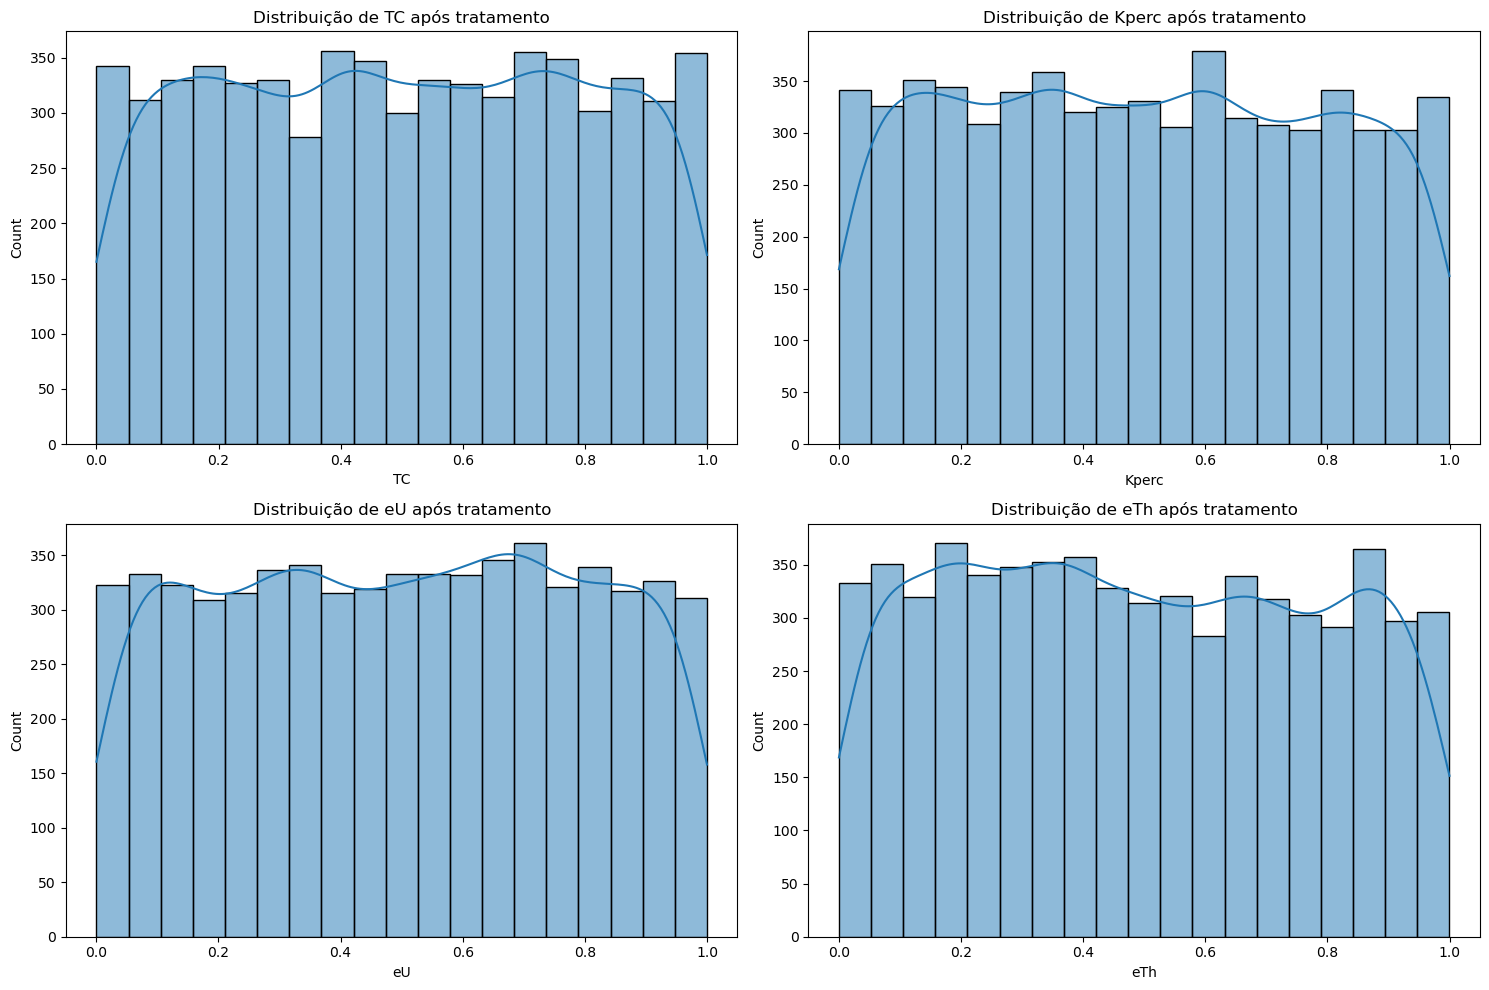

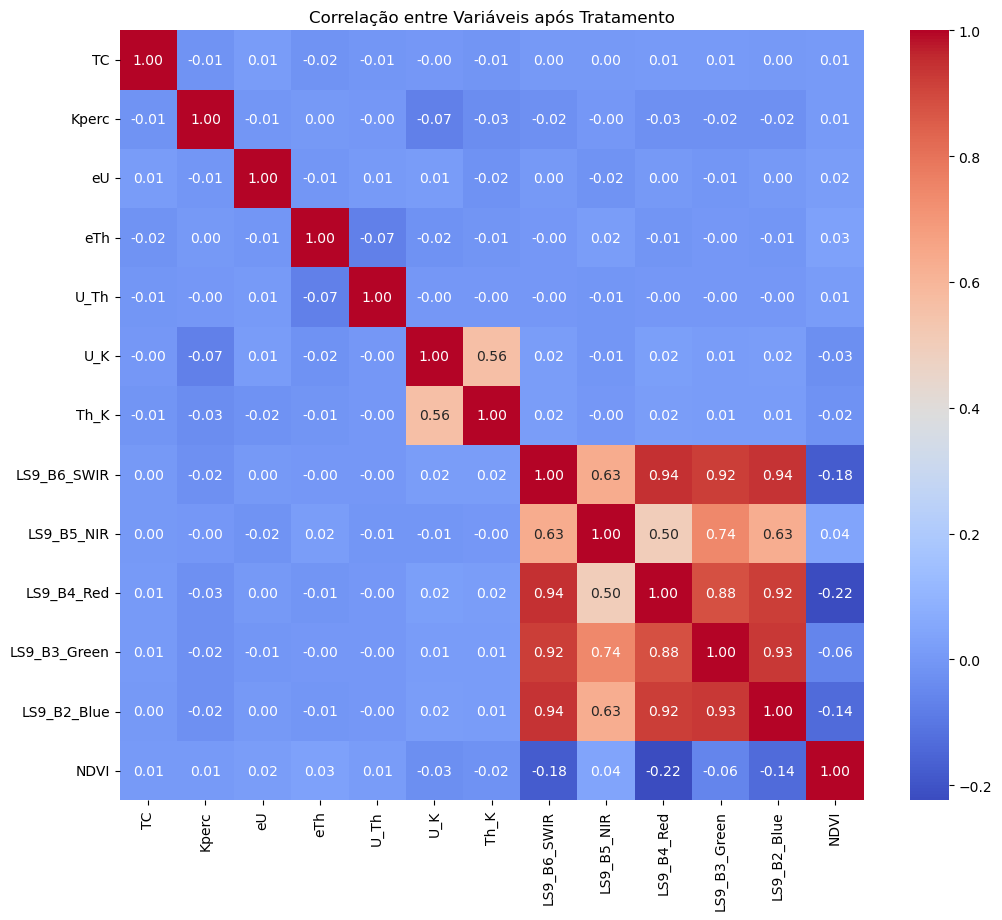

SIGLA_UNID
NP12vpf             1277
NP3sl                851
NP3sf                663
NP3an                658
NP3_gamma_ca         646
MP1_beta_am          639
NP3ps                508
NP3_beta_he          431
NP3C_cortado_1vz     323
NP3_alfa_avp         132
NP12vpfc              87
NP12vpfm              22
Name: count, dtype: int64


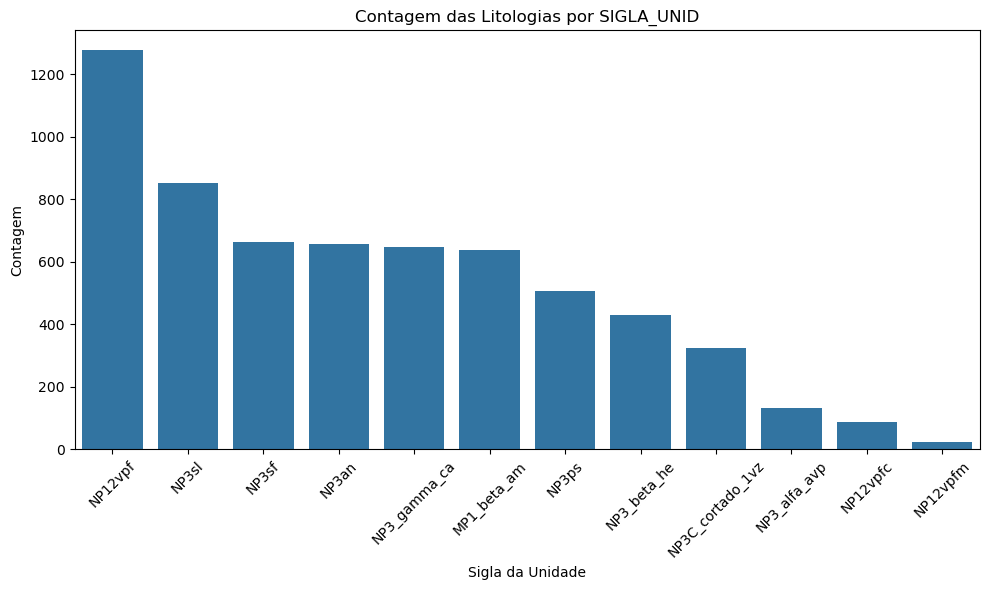

In [18]:
# 1. Verifique distribuições das variáveis tratadas
plt.figure(figsize=(15, 10))
for i, col in enumerate(radiometric_cols[:4], 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribuição de {col} após tratamento')
plt.tight_layout()
plt.show()

# 2. Mapa de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(df[radiometric_cols + spectral_cols[:5] + ['NDVI']].corr(), 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre Variáveis após Tratamento')
plt.show()

contagem_dos_locais = df['SIGLA_UNID'].value_counts()
print(contagem_dos_locais)
# Criar o gráfico de barras
plt.figure(figsize=(10, 6))  # Ajuste o tamanho conforme necessário
sns.barplot(x=contagem_dos_locais.index, y=contagem_dos_locais.values)

# Adicionar títulos e formatação
plt.title('Contagem das Litologias por SIGLA_UNID')
plt.xlabel('Sigla da Unidade')
plt.ylabel('Contagem')
plt.xticks(rotation=45)  # Rotaciona os rótulos para melhor legibilidade

# Mostrar o gráfico
plt.tight_layout()  # Ajusta o layout para evitar cortes
plt.show()

In [19]:
# Calcular médias por classe (excluindo colunas não espectrais)
spectral_bands = [col for col in df.columns if col not in ['SIGLA_UNID', 'COD_UNI_ES', 'fid','lon','lat']]
class_means = df.groupby('SIGLA_UNID')[spectral_bands].mean()

# Normalizar para comparação
class_means_norm = (class_means - class_means.min()) / (class_means.max() - class_means.min())

# Lista das classes que você quer plotar
classes_para_plotar = ['MP1_beta_am', 'NP3_beta_he'] # Substitua pelas classes desejadas

# Filtrar o DataFrame normalizado pelas classes de interesse
class_means_filtrado = class_means_norm.loc[classes_para_plotar]

# Plot
plt.figure(figsize=(14, 8))
for cls in class_means_filtrado.index:
    plt.plot(class_means_filtrado.columns, class_means_filtrado.loc[cls], label=cls)
plt.xticks(rotation=90)
plt.xlabel('Banda Espectral')
plt.ylabel('Reflectância Normalizada')
plt.title('Assinaturas Espectrais Médias por Classe MP1_beta_am e NP3_beta_he')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

TypeError: agg function failed [how->mean,dtype->geometry]

In [20]:
# Calcular médias por classe (excluindo colunas não espectrais)
spectral_bands = [col for col in df.columns if col not in ['SIGLA_UNID', 'COD_UNI_ES', 'fid','lon','lat']]
class_means = df.groupby('SIGLA_UNID')[spectral_bands].mean()

# Normalizar para comparação
class_means_norm = (class_means - class_means.min()) / (class_means.max() - class_means.min())

# Lista das classes que você quer plotar
classes_para_plotar = ['NP3sl', 'NP3sf', 'NP3ps', 'NP3an'] # Substitua pelas classes desejadas

# Filtrar o DataFrame normalizado pelas classes de interesse
class_means_filtrado = class_means_norm.loc[classes_para_plotar]

# Plot
plt.figure(figsize=(14, 8))
for cls in class_means_filtrado.index:
    plt.plot(class_means_filtrado.columns, class_means_filtrado.loc[cls], label=cls)
plt.xticks(rotation=90)
plt.xlabel('Banda Espectral')
plt.ylabel('Reflectância Normalizada')
plt.title('Assinaturas Espectrais Médias por Classe NP3sl, NP3sf, NP3ps')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

TypeError: agg function failed [how->mean,dtype->geometry]

In [21]:
# Calcular médias por classe (excluindo colunas não espectrais)
spectral_bands = [col for col in df.columns if col not in ['SIGLA_UNID', 'COD_UNI_ES', 'fid','lon','lat']]
class_means = df.groupby('SIGLA_UNID')[spectral_bands].mean()

# Normalizar para comparação
class_means_norm = (class_means - class_means.min()) / (class_means.max() - class_means.min())

# Lista das classes que você quer plotar
classes_para_plotar = ['NP12vpf', 'NP12vpfm', 'NP12vpfc'] # Substitua pelas classes desejadas

# Filtrar o DataFrame normalizado pelas classes de interesse
class_means_filtrado = class_means_norm.loc[classes_para_plotar]

# Plot
plt.figure(figsize=(14, 8))
for cls in class_means_filtrado.index:
    plt.plot(class_means_filtrado.columns, class_means_filtrado.loc[cls], label=cls)
plt.xticks(rotation=90)
plt.xlabel('Banda Espectral')
plt.ylabel('Reflectância Normalizada')
plt.title('Assinaturas Espectrais Médias por Classe NP12vpf, NP12vpfm e NP12vpfc')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

TypeError: agg function failed [how->mean,dtype->geometry]

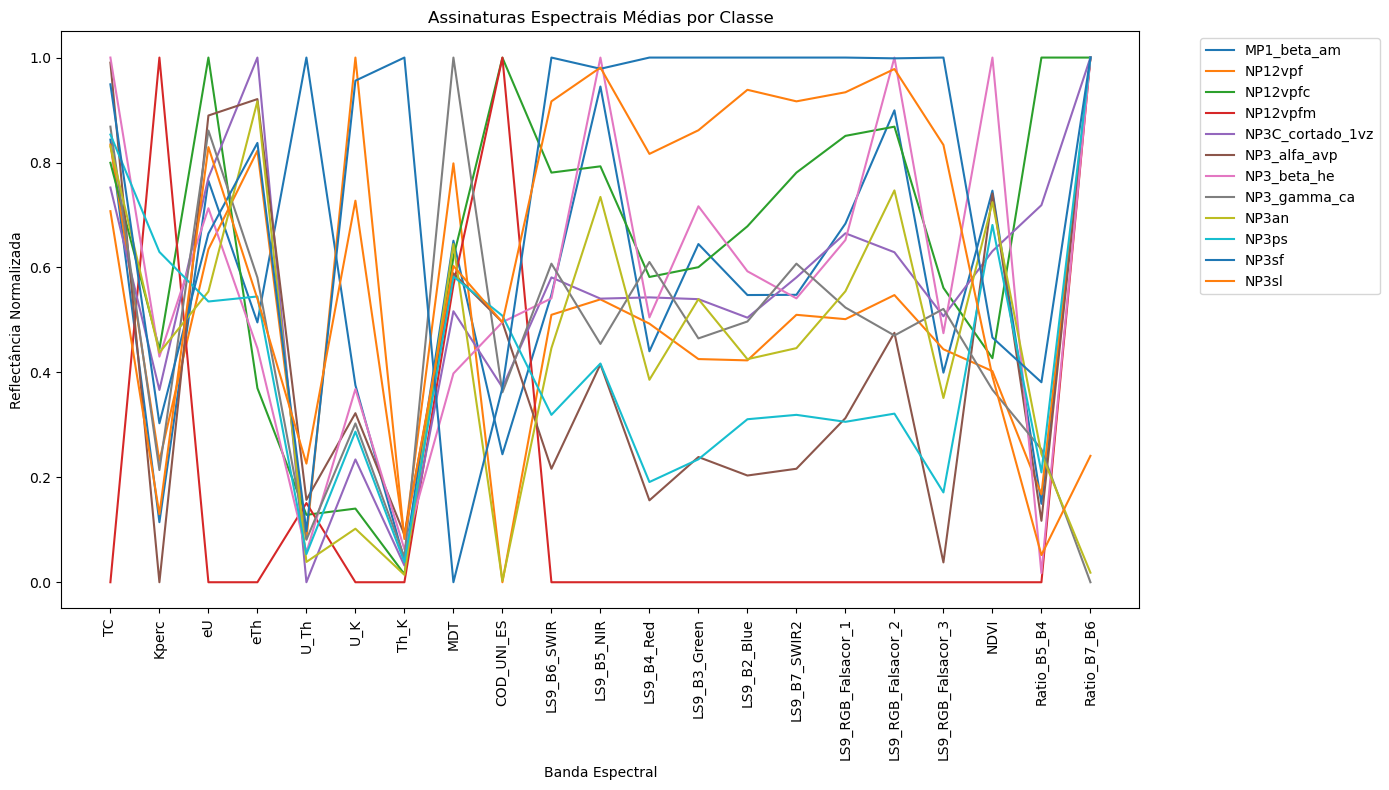

In [ ]:
# Calcular médias por classe (excluindo colunas não espectrais)
spectral_bands = [col for col in df.columns if col not in ['SIGLA_UNID','fid','lon','lat']]
class_means = df.groupby('SIGLA_UNID')[spectral_bands].mean()

# Normalizar para comparação
class_means_norm = (class_means - class_means.min()) / (class_means.max() - class_means.min())

# Plot
plt.figure(figsize=(14, 8))
for cls in class_means_norm.index:
    plt.plot(class_means_norm.columns, class_means_norm.loc[cls], label=cls)
plt.xticks(rotation=90)
plt.xlabel('Banda Espectral')
plt.ylabel('Reflectância Normalizada')
plt.title('Assinaturas Espectrais Médias por Classe')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Agregação de Classes 

SIGLA_AGG
NP3ps               2022
NP12vpf             1386
NP3an                658
NP3_gamma_ca         646
MP1_beta_am          639
NP3_beta_he          431
NP3C_cortado_1vz     323
NP3_alfa_avp         132
Name: count, dtype: int64


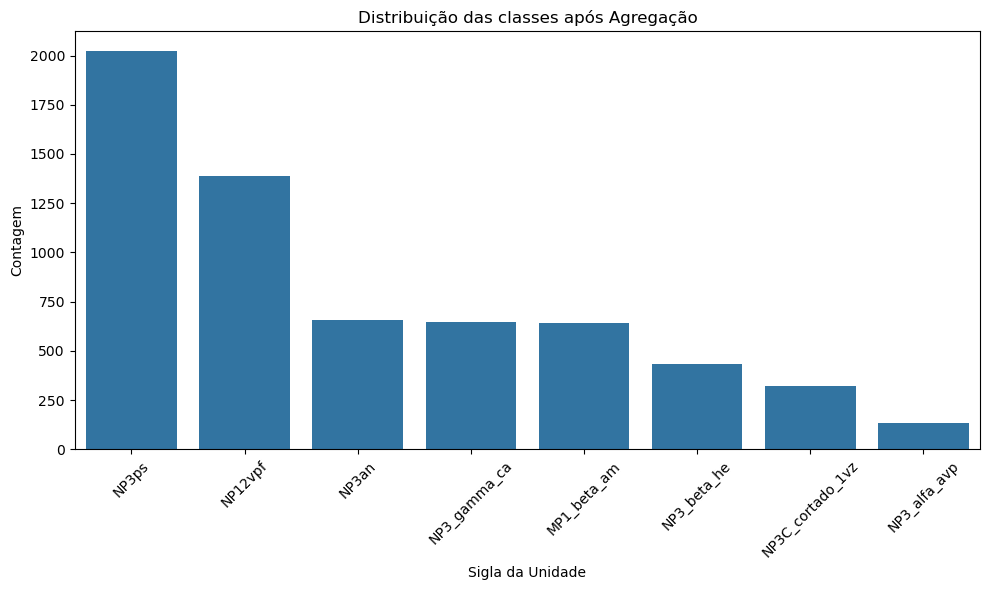

In [ ]:
regras_agreg = {
    #Junção das classes do COMPLEXO PASSO FEIO (NP12vpf)
    'NP12vpfc': 'NP12vpf', 
    'NP12vpfm': 'NP12vpf',   
    
    # Junção das classes do Grupo Santa Bárbara (NP3ps)
     'NP3sl': 'NP3ps', 
     'NP3sf': 'NP3ps',
     
 }

# Criar nova coluna com classes agregadas
df['SIGLA_AGG'] = df['SIGLA_UNID'].replace(regras_agreg)

contagem_dos_locais = df['SIGLA_AGG'].value_counts()
print(contagem_dos_locais)

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))  # Ajuste o tamanho conforme necessário
sns.barplot(x=contagem_dos_locais.index, y=contagem_dos_locais.values)

# Adicionar títulos e formatação
plt.title('Distribuição das classes após Agregação')
plt.xlabel('Sigla da Unidade')
plt.ylabel('Contagem')
plt.xticks(rotation=45)  # Rotaciona os rótulos para melhor legibilidade

# Mostrar o gráfico
plt.tight_layout()  # Ajusta o layout para evitar cortes
plt.show()

In [ ]:
area_status = df.groupby('SIGLA_AGG')[['TC', 'Kperc', 'eU', 'eTh', 'MDT']].describe()
print(area_status)

                      TC                                                    \
                   count      mean       std       min       25%       50%   
SIGLA_AGG                                                                    
MP1_beta_am        639.0  0.501287  0.285977  0.000549  0.258482  0.500463   
NP12vpf           1386.0  0.497534  0.296170  0.000447  0.227187  0.503339   
NP3C_cortado_1vz   323.0  0.487520  0.284093  0.004327  0.252284  0.460667   
NP3_alfa_avp       132.0  0.523412  0.295286  0.007194  0.265876  0.524392   
NP3_beta_he        431.0  0.524860  0.293014  0.001415  0.287212  0.536575   
NP3_gamma_ca       646.0  0.505011  0.297782  0.000746  0.241469  0.494080   
NP3an              658.0  0.499369  0.278096  0.002206  0.250986  0.516477   
NP3ps             2022.0  0.498210  0.286626  0.000044  0.253194  0.493283   

                                       Kperc            ...       eTh  \
                       75%       max   count      mean  ...       75

### Especificações de cores nos mapas 

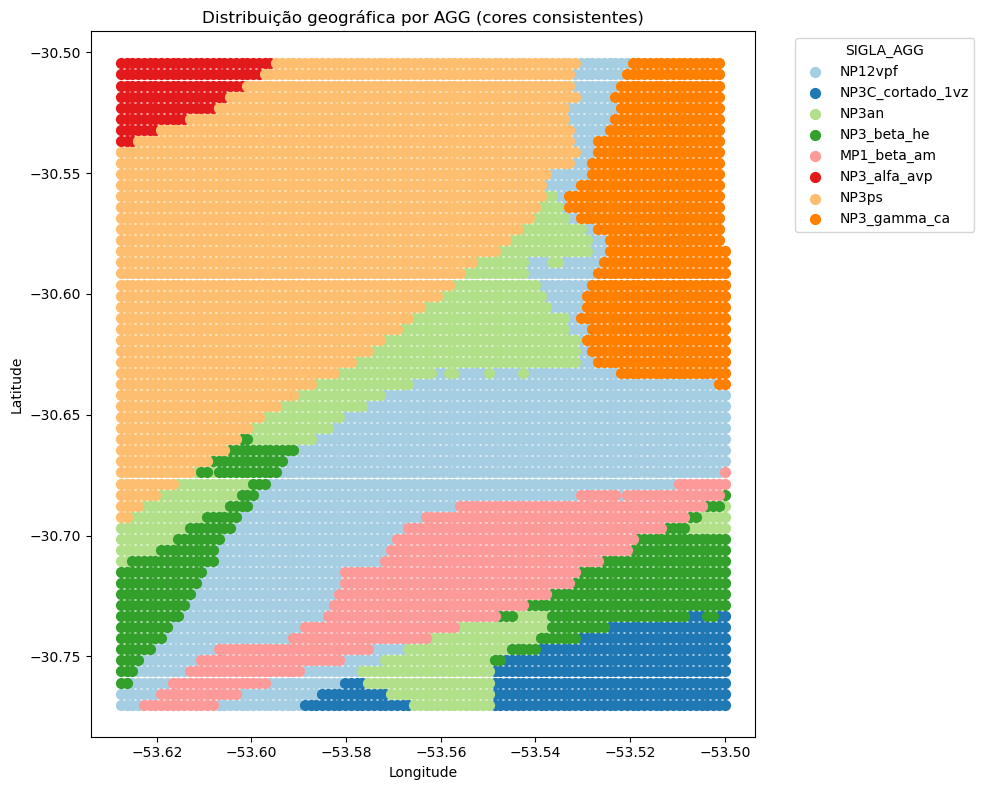

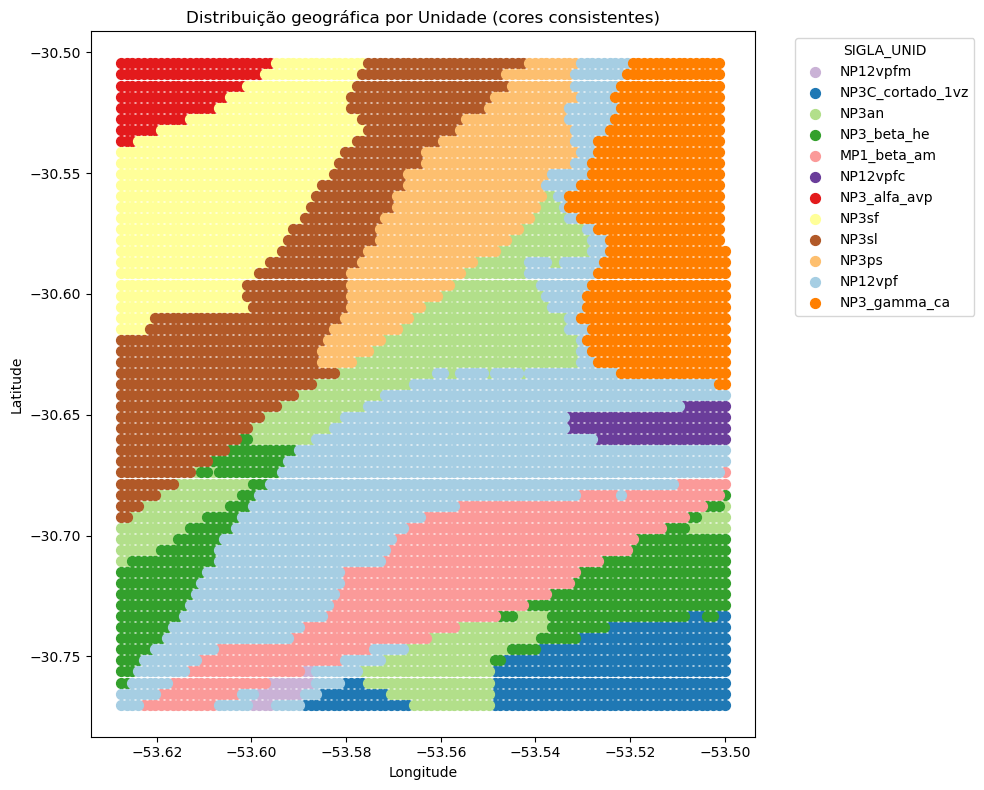

In [167]:
# Primeiro, vamos criar um dicionário de cores único para todas as siglas
all_siglas = pd.concat([df['SIGLA_AGG'], df['SIGLA_UNID']]).unique()
cores = plt.cm.Paired(np.linspace(0, 1, len(all_siglas)))
color_dict = {sigla: cores[i] for i, sigla in enumerate(all_siglas)}

# Função para plotar com cores consistentes
def plot_map(coluna, titulo):
    plt.figure(figsize=(10, 8))
    for sigla in df[coluna].unique():
        mask = df[coluna] == sigla
        plt.scatter(df.loc[mask, 'lon'], df.loc[mask, 'lat'], 
                   color=color_dict[sigla], label=sigla, s=50)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=coluna)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(titulo)
    plt.tight_layout()
    plt.show()

# Plotando os mapas
plot_map('SIGLA_AGG', 'Distribuição geográfica por AGG (cores consistentes)')
plot_map('SIGLA_UNID', 'Distribuição geográfica por Unidade (cores consistentes)')

In [168]:
# Listar tipos de dados de cada coluna
print(df.dtypes)

# Ou identificar colunas não numéricas
non_numeric = df.select_dtypes(exclude=['number']).columns
print("Colunas não numéricas:", list(non_numeric))

fid                     int64
lon                   float64
lat                   float64
TC                    float64
Kperc                 float64
eU                    float64
eTh                   float64
U_Th                  float64
U_K                   float64
Th_K                  float64
MDT                   float64
COD_UNI_ES            float64
SIGLA_UNID             object
LS9_B6_SWIR           float64
LS9_B5_NIR            float64
LS9_B4_Red            float64
LS9_B3_Green          float64
LS9_B2_Blue           float64
LS9_B7_SWIR2          float64
LS9_RGB_Falsacor_1    float64
LS9_RGB_Falsacor_2    float64
LS9_RGB_Falsacor_3    float64
NDVI                  float64
Ratio_B5_B4           float64
Ratio_B7_B6           float64
SIGLA_AGG              object
dtype: object
Colunas não numéricas: ['SIGLA_UNID', 'SIGLA_AGG']


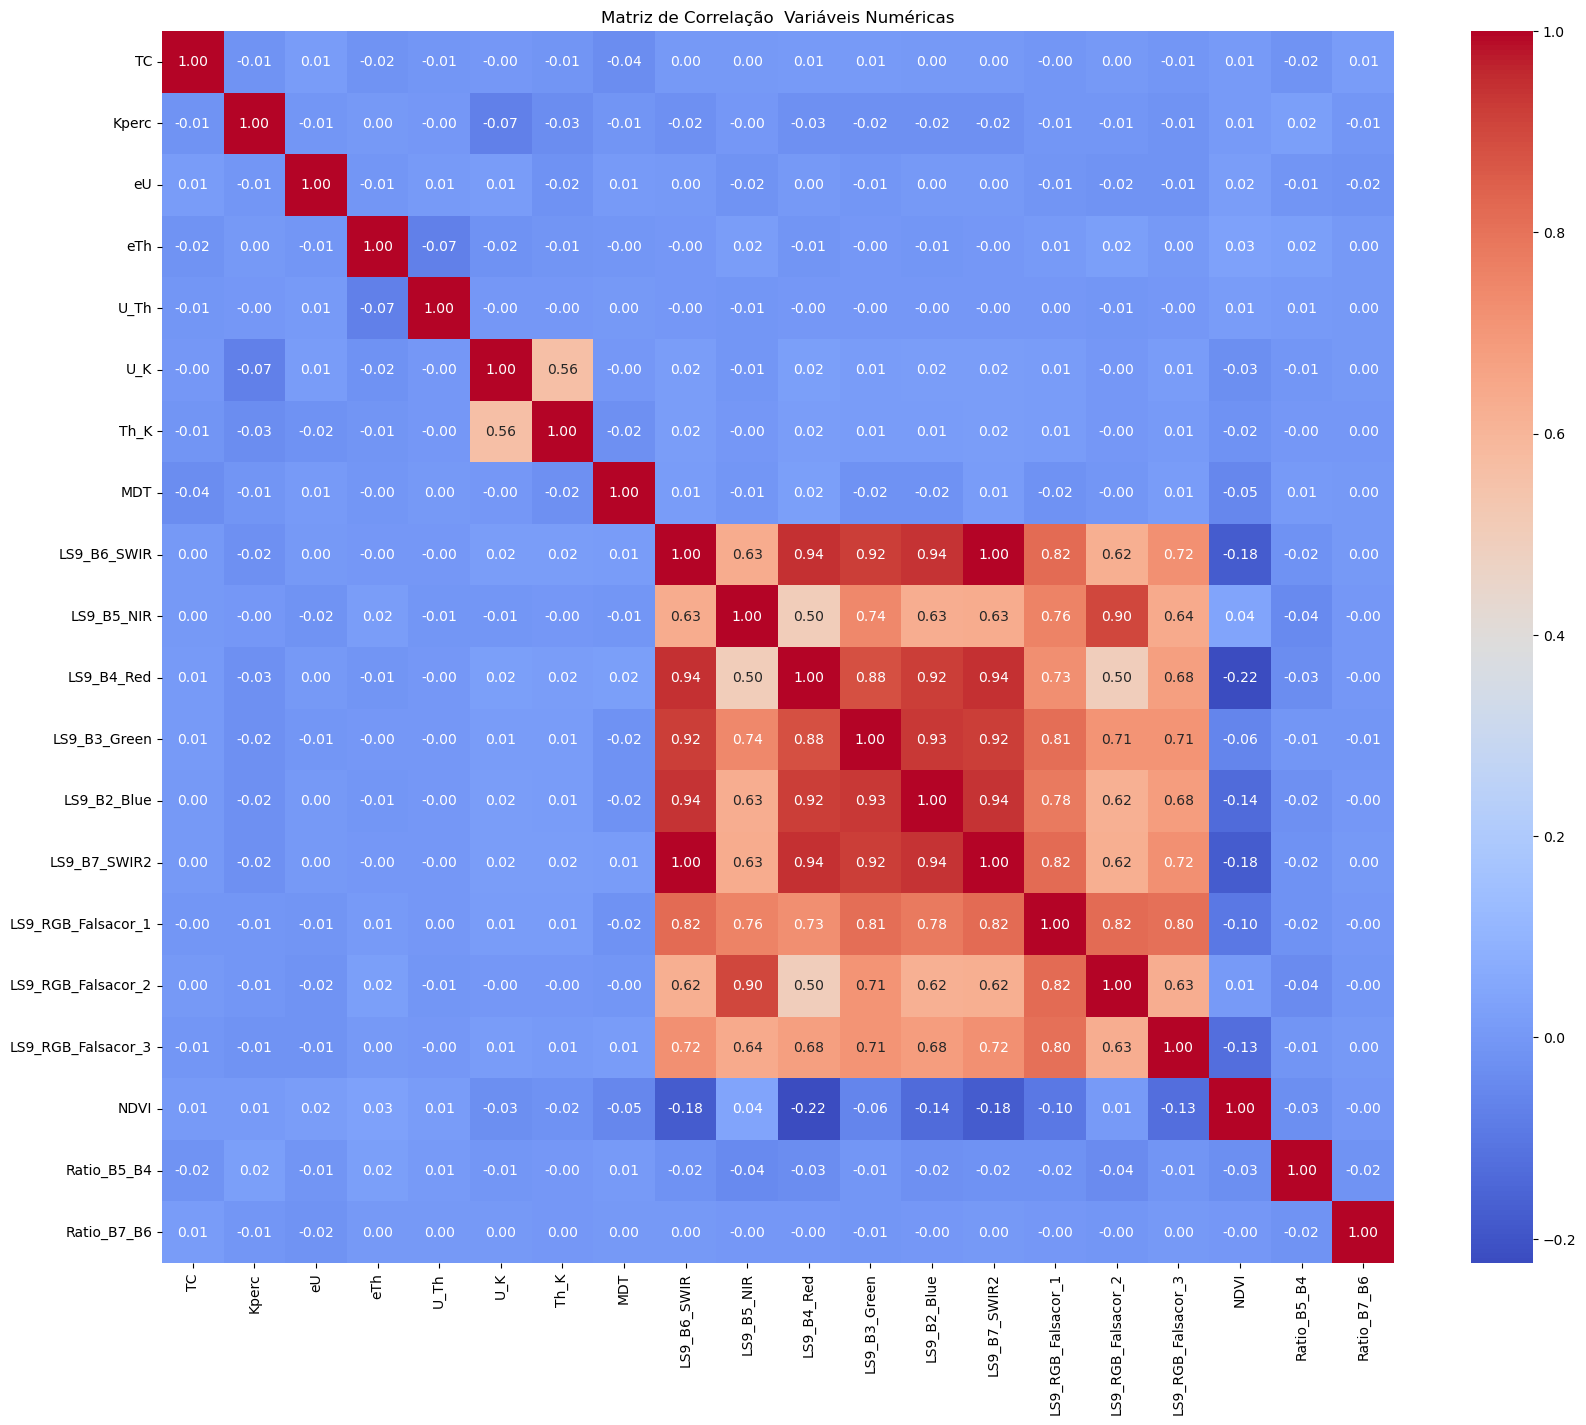

In [169]:
# Selecionar apenas colunas numéricas
numeric_df = df.select_dtypes(include=['number'])

# Remover colunas específicas que não queremos 
cols_to_drop = ['fid', 'lon', 'lat', 'COD_UNI_ES']  
numeric_df = numeric_df.drop([col for col in cols_to_drop if col in numeric_df.columns], axis=1)

# Calcular a matriz de correlação
corr_matrix = numeric_df.corr()

# Plotar
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f')
plt.title('Matriz de Correlação  Variáveis Numéricas')
plt.show()

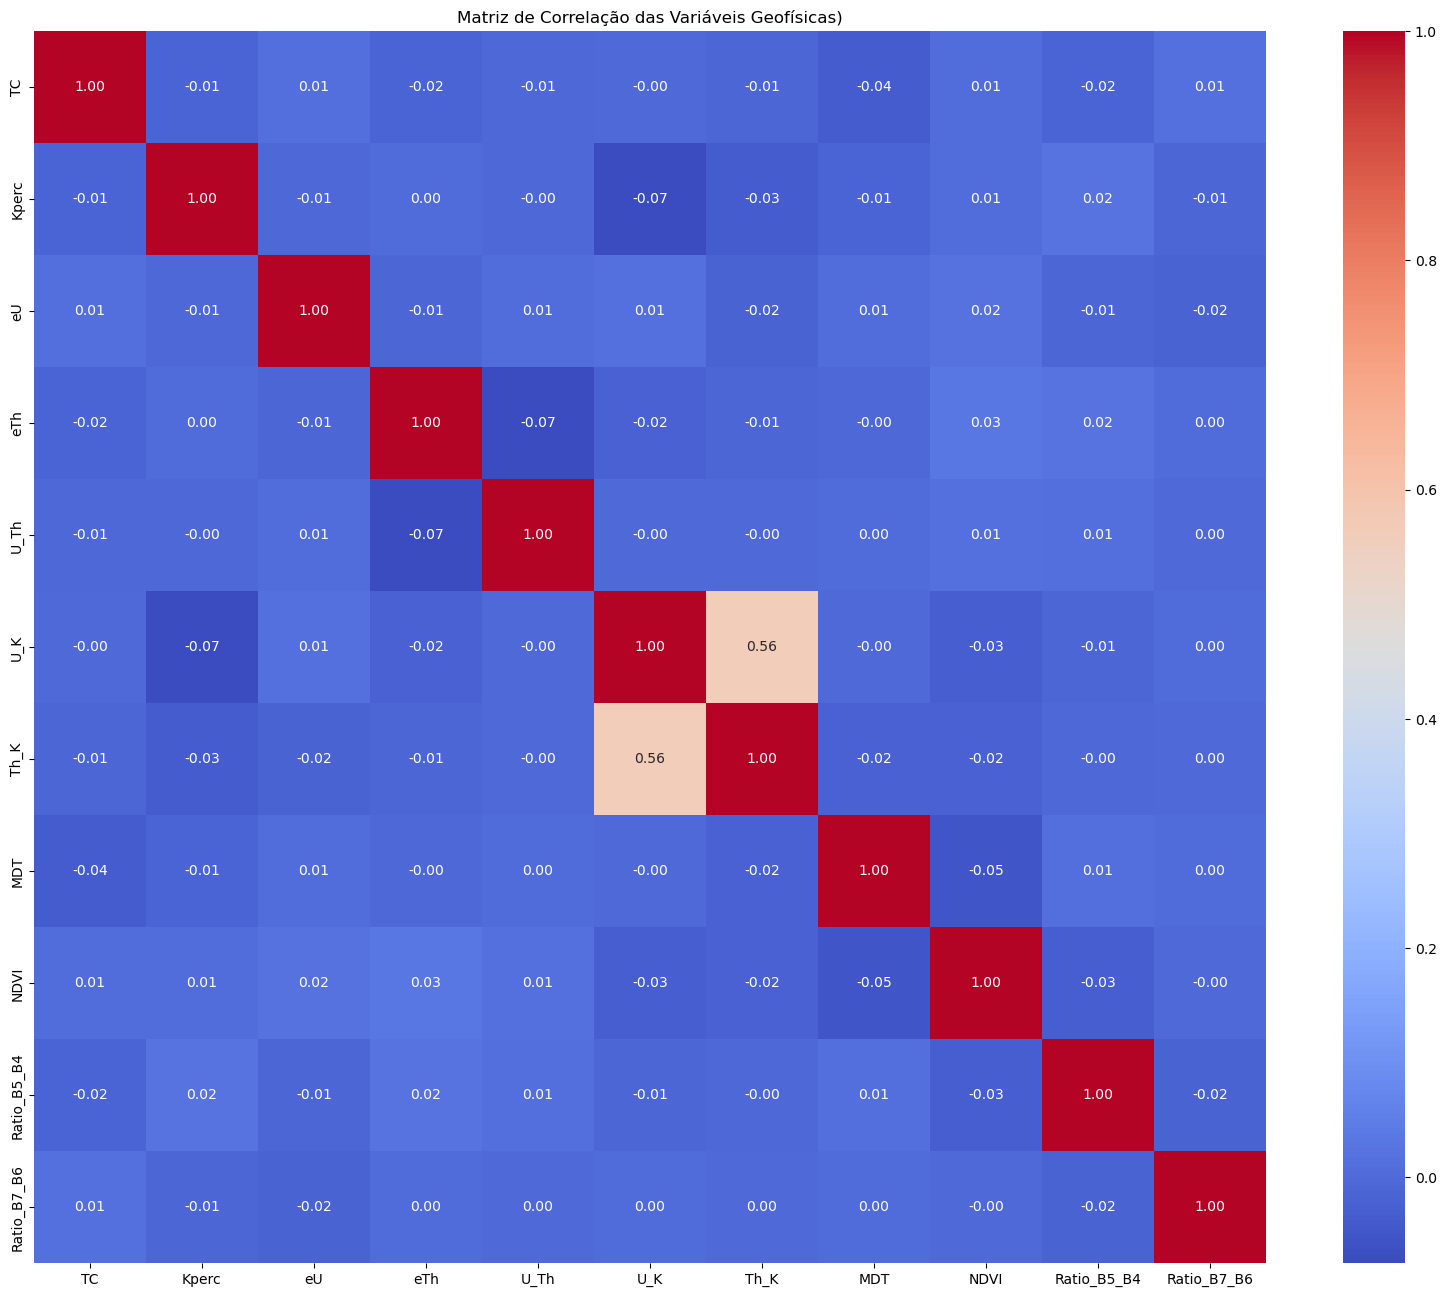

In [170]:
# Selecionar apenas colunas numéricas
numeric_df = df.select_dtypes(include=['number'])

# Remover colunas específicas que não queremos 
cols_to_drop = ['fid', 'lon', 'lat', 'SIGLA_AGG', 'COD_UNI_ES', 'LS9_B6_SWIR',
 'LS9_B5_NIR',
 'LS9_B4_Red',
 'LS9_B3_Green',
 'LS9_B2_Blue',
 'LS9_B7_SWIR2',
 'LS9_RGB_Falsacor_1',
 'LS9_RGB_Falsacor_2',
 'LS9_RGB_Falsacor_3']  
numeric_df = numeric_df.drop([col for col in cols_to_drop if col in numeric_df.columns], axis=1)

# Calcular a matriz de correlação
corr_matrix = numeric_df.corr()

# Plotar
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f')
plt.title('Matriz de Correlação das Variáveis Geofísicas)')
plt.show()




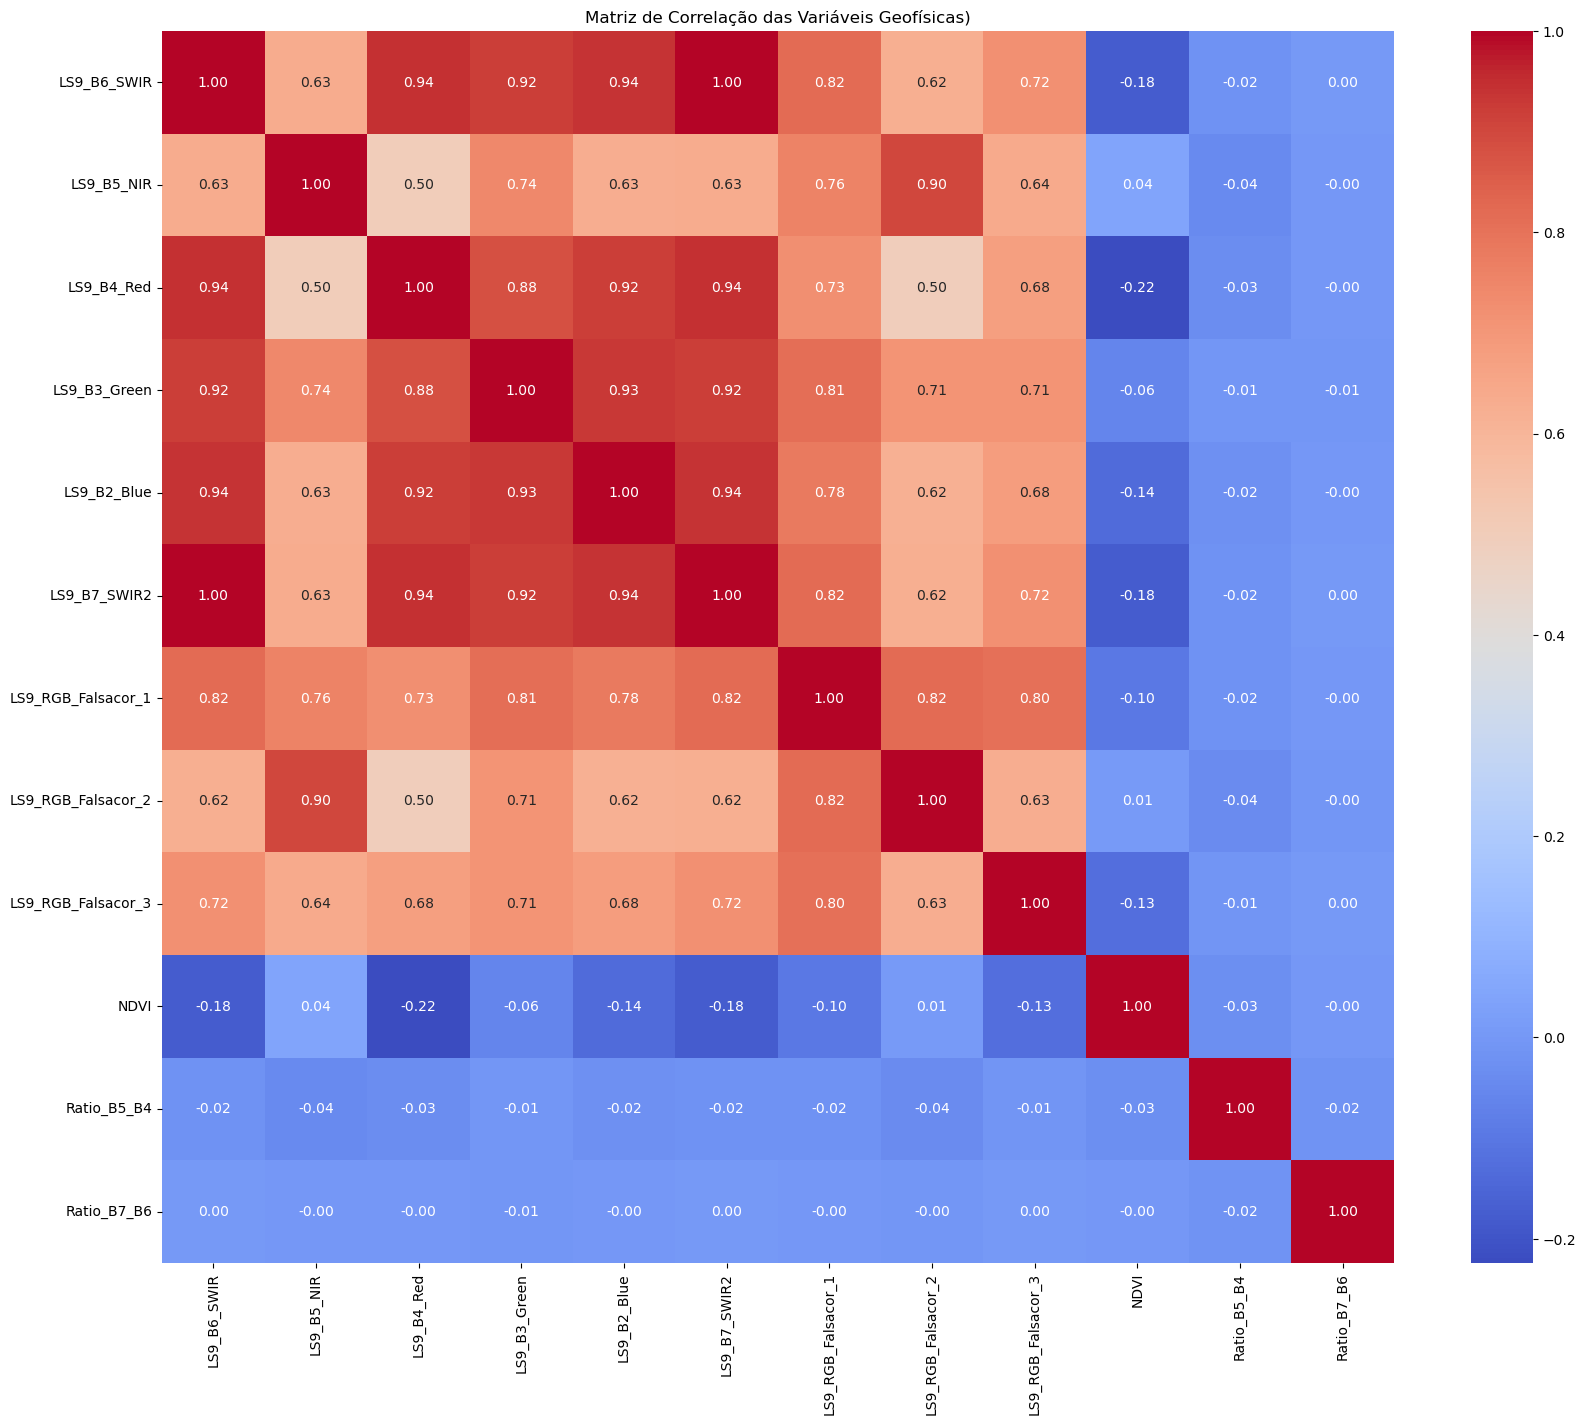

In [171]:


# Selecionar apenas colunas numéricas
numeric_df = df.select_dtypes(include=['number'])

# Remover colunas específicas que não queremos (se necessário)
cols_to_drop = ['fid', 'lon', 'lat', 'SIGLA_AGG', 'COD_UNI_ES','TC',
 'Kperc',
 'eU',
 'eTh',
 'U_Th',
 'U_K',
 'Th_K',
 'MDT']  # Exemplo
numeric_df = numeric_df.drop([col for col in cols_to_drop if col in numeric_df.columns], axis=1)

# Calcular a matriz de correlação
corr_matrix = numeric_df.corr()

# Plotar
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f')
plt.title('Matriz de Correlação das Variáveis Geofísicas)')
plt.show()


### Criando o modelo a partir do Random Forest

In [172]:
# Definindo X e y (todas as amostras)
X = df.drop(['fid','SIGLA_AGG', 'COD_UNI_ES'], axis=1)  # Exclui target + IDs
y = df['SIGLA_AGG']  # Ou 'COD_UNI_ES', conforme seu target

# Verificação global
print("Variáveis preditoras (X):", X.columns.tolist())
print("Variável target (y):", y.name)
print("\nShape de X (todas amostras):", X.shape)
print("Shape de y (todas amostras):", y.shape)
print("\nDistribuição original das classes:\n", y.value_counts())

Variáveis preditoras (X): ['lon', 'lat', 'TC', 'Kperc', 'eU', 'eTh', 'U_Th', 'U_K', 'Th_K', 'MDT', 'SIGLA_UNID', 'LS9_B6_SWIR', 'LS9_B5_NIR', 'LS9_B4_Red', 'LS9_B3_Green', 'LS9_B2_Blue', 'LS9_B7_SWIR2', 'LS9_RGB_Falsacor_1', 'LS9_RGB_Falsacor_2', 'LS9_RGB_Falsacor_3', 'NDVI', 'Ratio_B5_B4', 'Ratio_B7_B6']
Variável target (y): SIGLA_AGG

Shape de X (todas amostras): (6237, 23)
Shape de y (todas amostras): (6237,)

Distribuição original das classes:
 SIGLA_AGG
NP3ps               2022
NP12vpf             1386
NP3an                658
NP3_gamma_ca         646
MP1_beta_am          639
NP3_beta_he          431
NP3C_cortado_1vz     323
NP3_alfa_avp         132
Name: count, dtype: int64


In [173]:
# 1. Definir features e target
features = [  'lon', 'lat','TC', 'Kperc', 'eU', 'eTh', 'U_Th', 'U_K', 'Th_K', 
           'LS9_B2_Blue', 'LS9_B3_Green', 'LS9_B4_Red',
           'LS9_B5_NIR', 'LS9_B6_SWIR', 'LS9_B7_SWIR2']
target = 'SIGLA_AGG'  # ou 'COD_UNI_ES'

# 2. Amostragem estratificada - garantindo 150 por classe no treino
train_data = pd.DataFrame()

for classe in df[target].unique():
    classe_df = df[df[target] == classe]
    
    if len(classe_df) >= 150:
        # Pegar 150 para treino e o resto vai para teste
        train_classe = classe_df.sample(n=150, random_state=42)
        train_data = pd.concat([train_data, train_classe])
    else:
        # Se menos que 150, usar 70% para treino
        train_classe, _ = train_test_split(classe_df, train_size=0.7, random_state=42)
        train_data = pd.concat([train_data, train_classe])

# 3. Conjunto de teste é tudo que não está no treino
test_data = df[~df.index.isin(train_data.index)]

# 4. Separar features e target
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# 5. Verificação
print(f"Treino: {len(X_train)} amostras")
print(f"Teste: {len(X_test)} amostras")
print("\nDistribuição no treino:")
print(y_train.value_counts())
print("\nDistribuição no teste:")
print(y_test.value_counts())

Treino: 1142 amostras
Teste: 5095 amostras

Distribuição no treino:
SIGLA_AGG
NP12vpf             150
NP3C_cortado_1vz    150
NP3an               150
NP3_beta_he         150
MP1_beta_am         150
NP3ps               150
NP3_gamma_ca        150
NP3_alfa_avp         92
Name: count, dtype: int64

Distribuição no teste:
SIGLA_AGG
NP3ps               1872
NP12vpf             1236
NP3an                508
NP3_gamma_ca         496
MP1_beta_am          489
NP3_beta_he          281
NP3C_cortado_1vz     173
NP3_alfa_avp          40
Name: count, dtype: int64


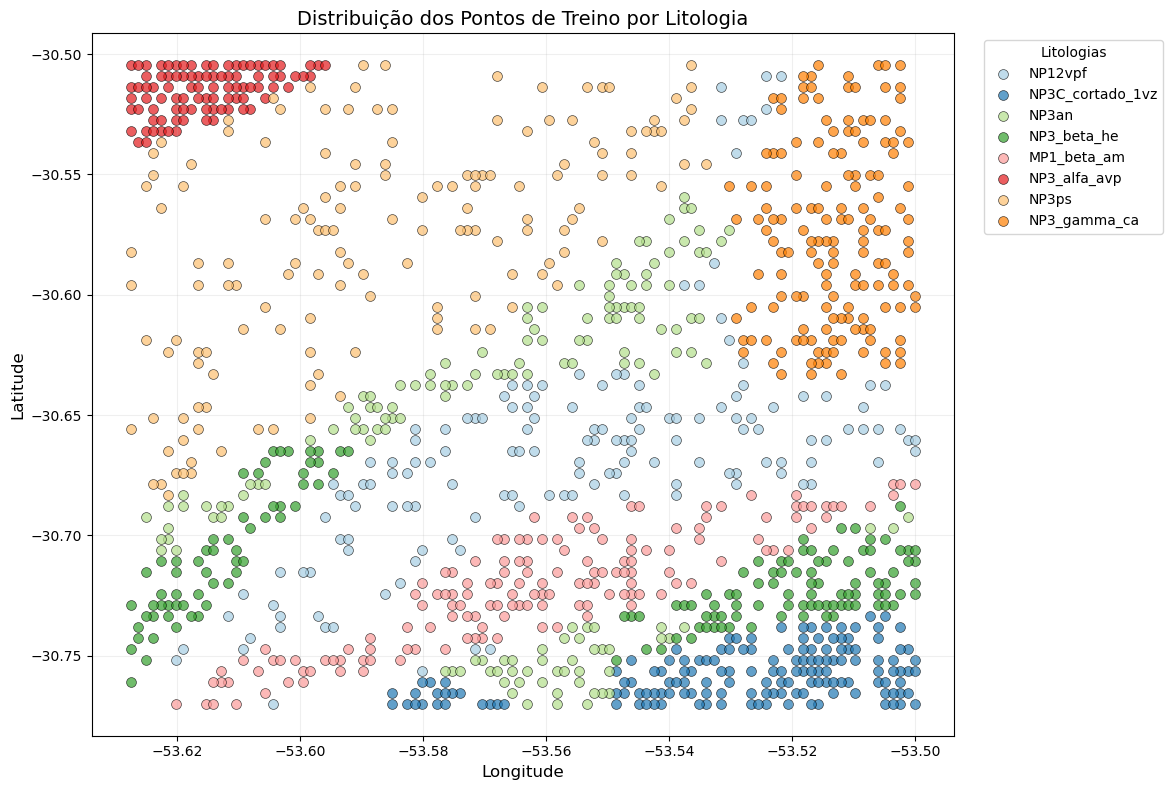

In [ ]:
# Configuração das cores das litologias (compartilhada entre as células)
litologias_unicas = pd.concat([df['SIGLA_AGG'], df['SIGLA_UNID']]).unique()
cores = plt.cm.Paired(np.linspace(0, 1, len(litologias_unicas)))  # Paleta "Paired" do matplotlib
color_dict = {litologia: cores[i] for i, litologia in enumerate(litologias_unicas)}

# Visualização dos dados de treino
plt.figure(figsize=(12, 8))
for litologia in train_data[target].unique():
    subset = train_data[train_data[target] == litologia]
    plt.scatter(
        subset['lon'], 
        subset['lat'], 
        color=color_dict[litologia],  # Mesma cor para cada litologia
        label=litologia, 
        s=50, 
        alpha=0.7,
        edgecolor='k',  
        linewidth=0.5
    )
    
plt.legend(bbox_to_anchor=(1.25, 1), title='Litologias', fontsize=10)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Distribuição dos Pontos de Treino por Litologia', fontsize=14)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

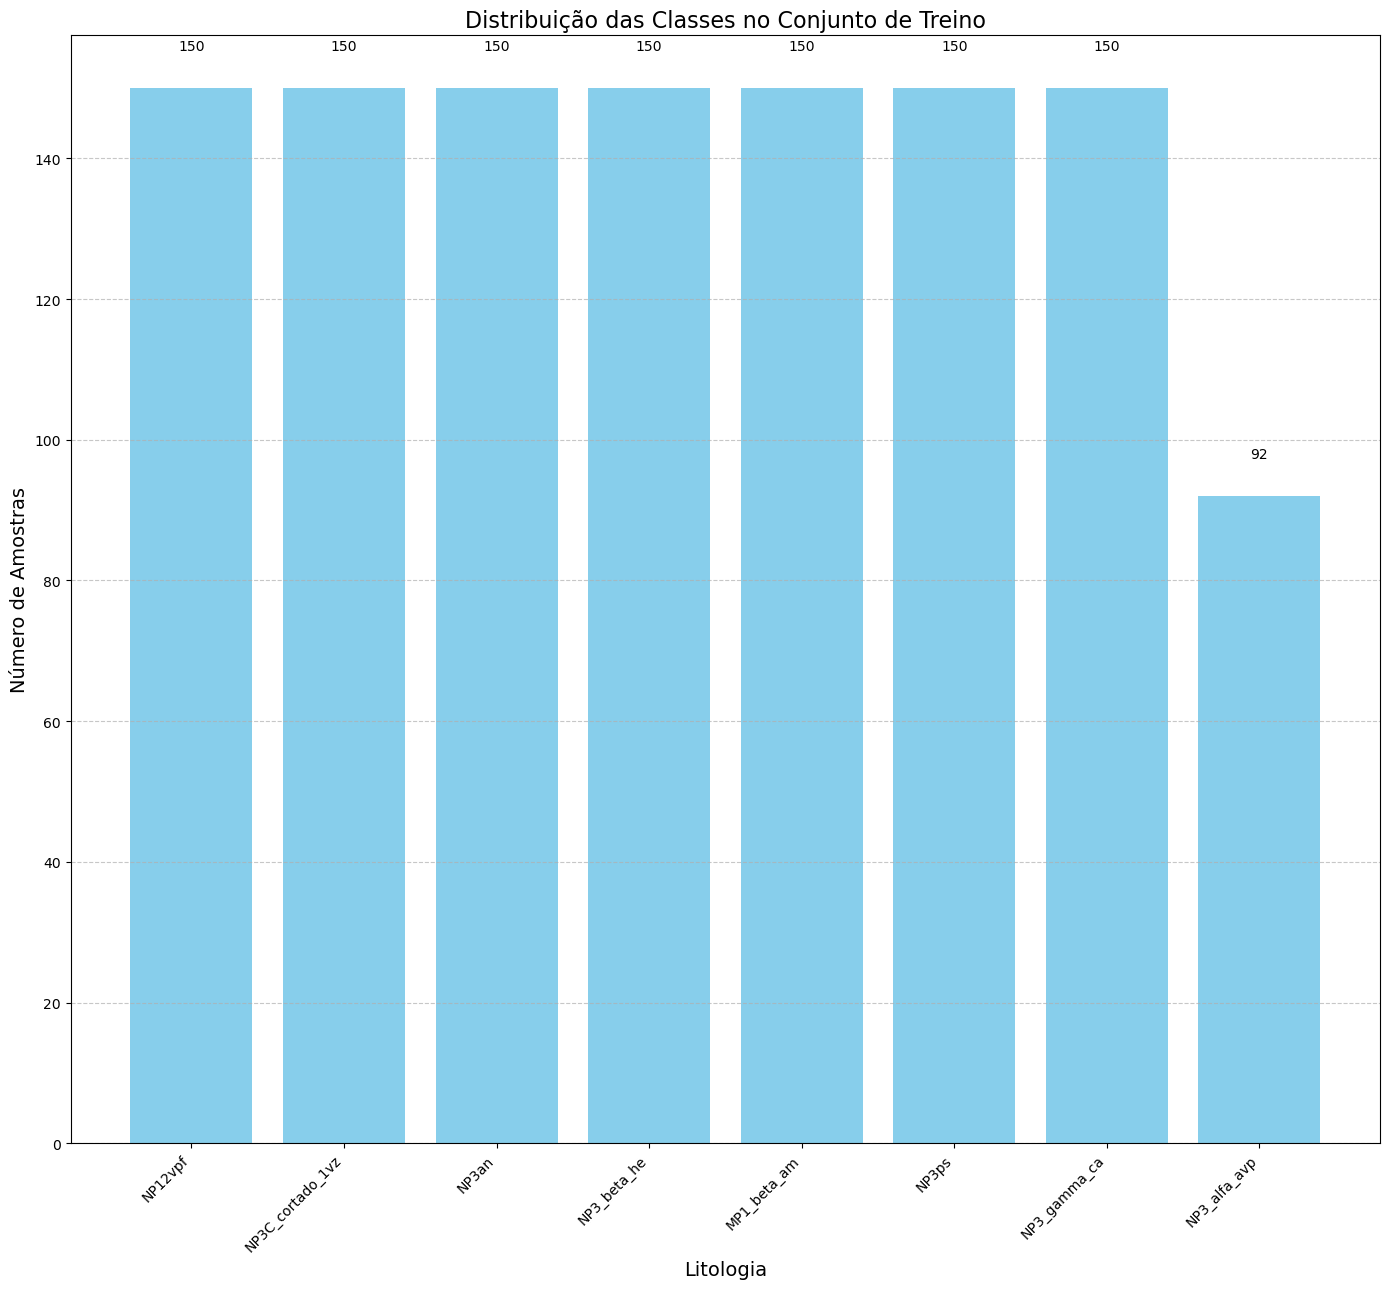

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Preparar os dados
class_dist = y_train.value_counts().reset_index()
class_dist.columns = ['Litologia', 'Quantidade']
class_dist = class_dist.sort_values('Quantidade', ascending=False)

# 2. Criar figura
plt.figure(figsize=(14, 13))

# Opção 1: Gráfico de barras simples (matplotlib)
plt.bar(class_dist['Litologia'], class_dist['Quantidade'], color='skyblue')
plt.title('Distribuição das Classes no Conjunto de Treino', fontsize=16)
plt.xlabel('Litologia', fontsize=14)
plt.ylabel('Número de Amostras', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar valores nas barras
for i, value in enumerate(class_dist['Quantidade']):
    plt.text(i, value + 5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()



In [176]:
df_treino = train_data

# Save to CSV
df_treino.to_csv('treino_PFeio_AGG.csv', index=False)

print('CSV salvo com sucesso !!')

CSV salvo com sucesso !!


### SMOTE

In [177]:

#smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
#X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train)
X_train_smt, y_train_smt = SMOTE().fit_resample(X_train, y_train)

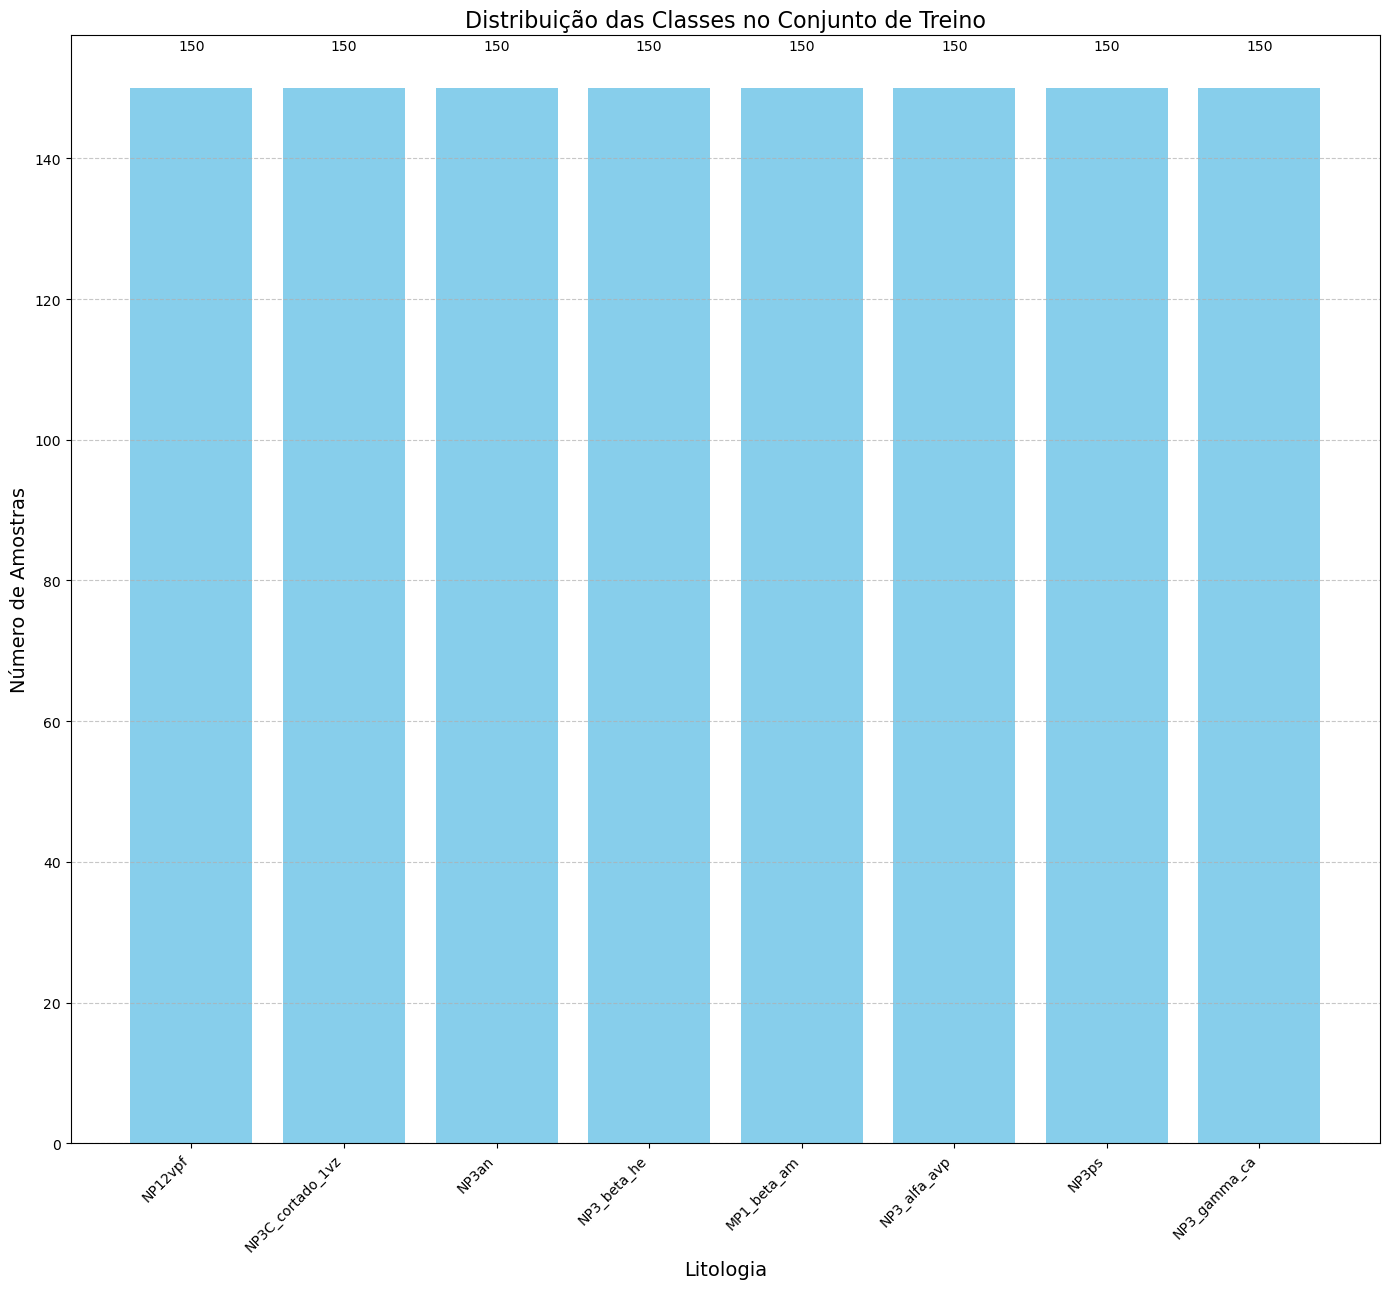

In [178]:
class_dist = y_train_smt.value_counts().reset_index()
class_dist.columns = ['Litologia', 'Quantidade']
class_dist = class_dist.sort_values('Quantidade', ascending=False)

# 2. Criar figura
plt.figure(figsize=(14, 13))

# Opção 1: Gráfico de barras simples (matplotlib)
plt.bar(class_dist['Litologia'], class_dist['Quantidade'], color='skyblue')
plt.title('Distribuição das Classes no Conjunto de Treino', fontsize=16)
plt.xlabel('Litologia', fontsize=14)
plt.ylabel('Número de Amostras', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar valores nas barras
for i, value in enumerate(class_dist['Quantidade']):
    plt.text(i, value + 5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()



In [ ]:



# Pipeline com pré-processamento
pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Menos sensível a outliers que StandardScaler
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced_subsample'  # Versão melhorada para RF
    ))
])

# Grade de parâmetros expandida
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt']  # Adicionado controle de features
}

# Usando validação cruzada estratificada e balanced_accuracy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='balanced_accuracy',  # Melhor para classes desbalanceadas
    n_jobs=-1,
    verbose=2  # Mostra progresso
)

grid_search.fit(X_train_smt, y_train_smt)  # Usando dados balanceados

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced_subsample',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__max_features': ['sqrt'],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='balanced_accuracy', verbose=2)

In [181]:
# Obter o melhor modelo
best_rf = grid_search.best_estimator_

# Fazer previsões
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)

# Métricas básicas
print(f"Melhores parâmetros: {grid_search.best_params_}\n")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"Acurácia Balanceada: {balanced_accuracy_score(y_test, y_pred):.4f}\n")
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

Melhores parâmetros: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

Acurácia: 0.7641
Acurácia Balanceada: 0.7796

Relatório de Classificação:
                   precision    recall  f1-score   support

     MP1_beta_am     0.5480    0.7117    0.6192       489
         NP12vpf     0.8705    0.5494    0.6736      1236
NP3C_cortado_1vz     0.8060    0.9364    0.8663       173
    NP3_alfa_avp     0.4722    0.8500    0.6071        40
     NP3_beta_he     0.4060    0.7224    0.5198       281
    NP3_gamma_ca     0.8153    0.9879    0.8933       496
           NP3an     0.5684    0.5807    0.5745       508
           NP3ps     0.9412    0.8985    0.9194      1872

        accuracy                         0.7641      5095
       macro avg     0.6785    0.7796    0.7092      5095
    weighted avg     0.7991    0.7641    0.7677      5095



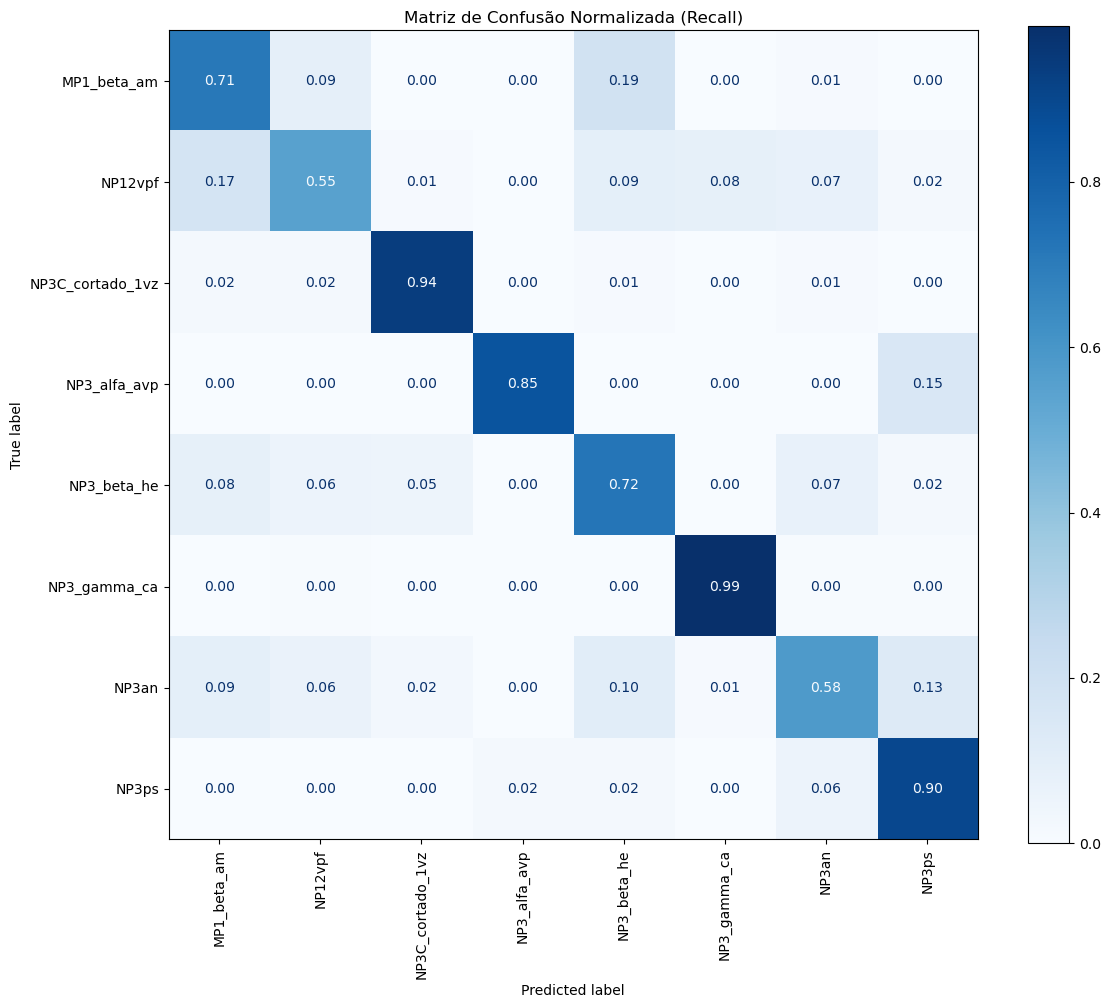

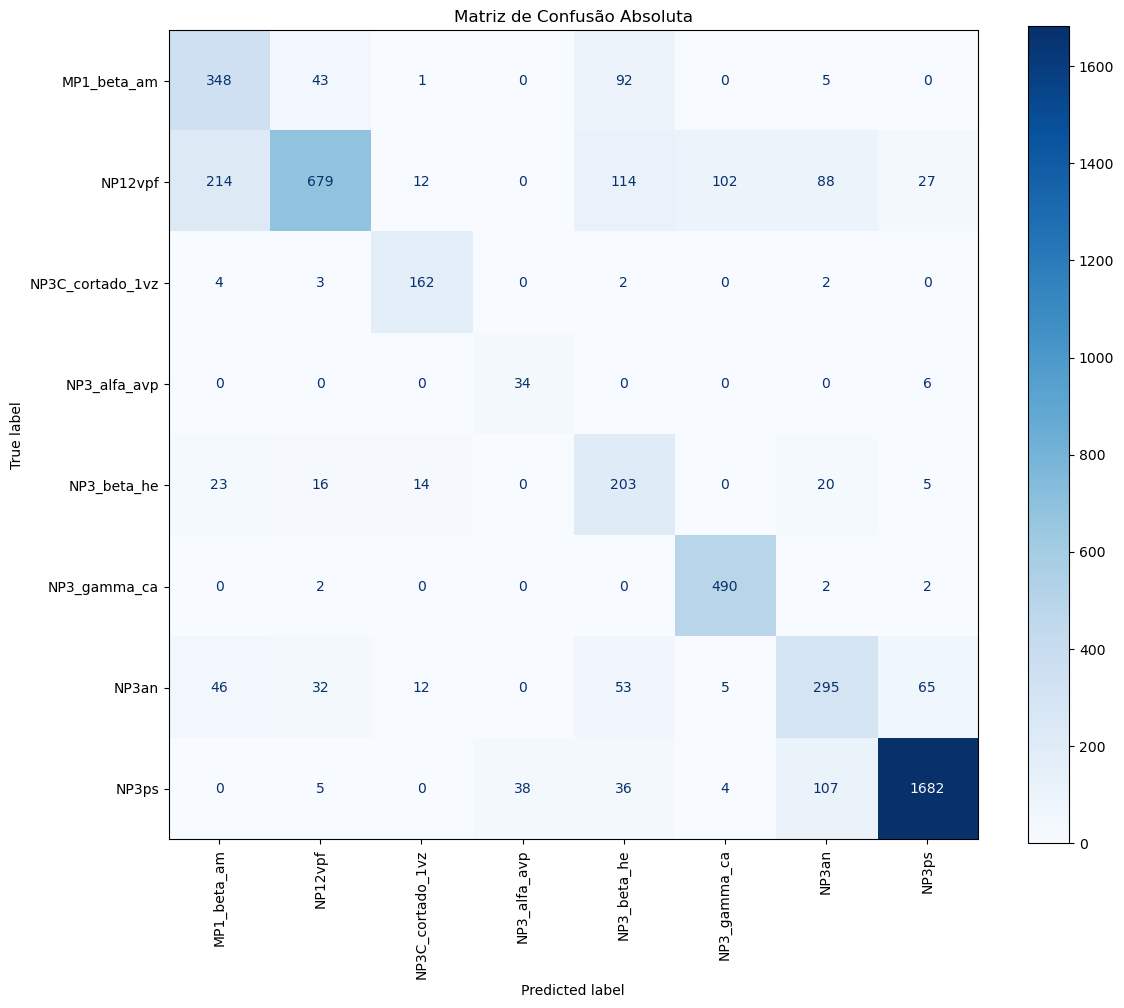

In [ ]:


# Matriz de confusão normalizada por linha (recall)
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    normalize='true',
    cmap='Blues',
    ax=ax,
    values_format='.2f',
    xticks_rotation=90
)
plt.title('Matriz de Confusão Normalizada (Recall)')
plt.tight_layout()
plt.show()

# Matriz de confusão absoluta
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap='Blues',
    ax=ax,
    values_format='d',
    xticks_rotation=90
)
plt.title('Matriz de Confusão Absoluta')
plt.tight_layout()
plt.show()

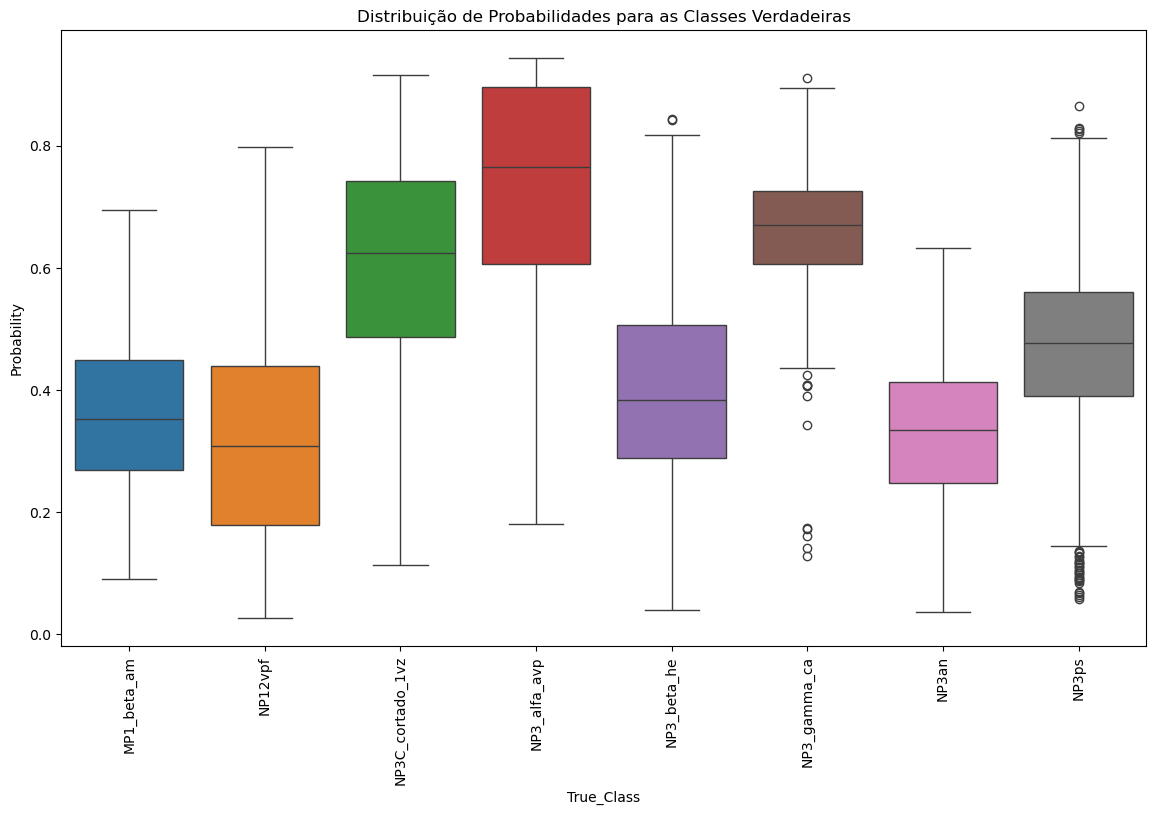

In [ ]:
# DataFrame com probabilidades
prob_df = pd.DataFrame(y_proba, columns=best_rf.classes_)
prob_df['True_Class'] = y_test.reset_index(drop=True)
prob_df['Predicted_Class'] = y_pred


melted_probs = prob_df.melt(id_vars=['True_Class', 'Predicted_Class'], 
                           var_name='Class', 
                           value_name='Probability')

plt.figure(figsize=(14, 8))
sns.boxplot(x='True_Class', y='Probability', hue='Class', 
            data=melted_probs[melted_probs['Class'] == melted_probs['True_Class']])
plt.title('Distribuição de Probabilidades para as Classes Verdadeiras')
plt.xticks(rotation=90)
plt.legend([], [], frameon=False)
plt.show()

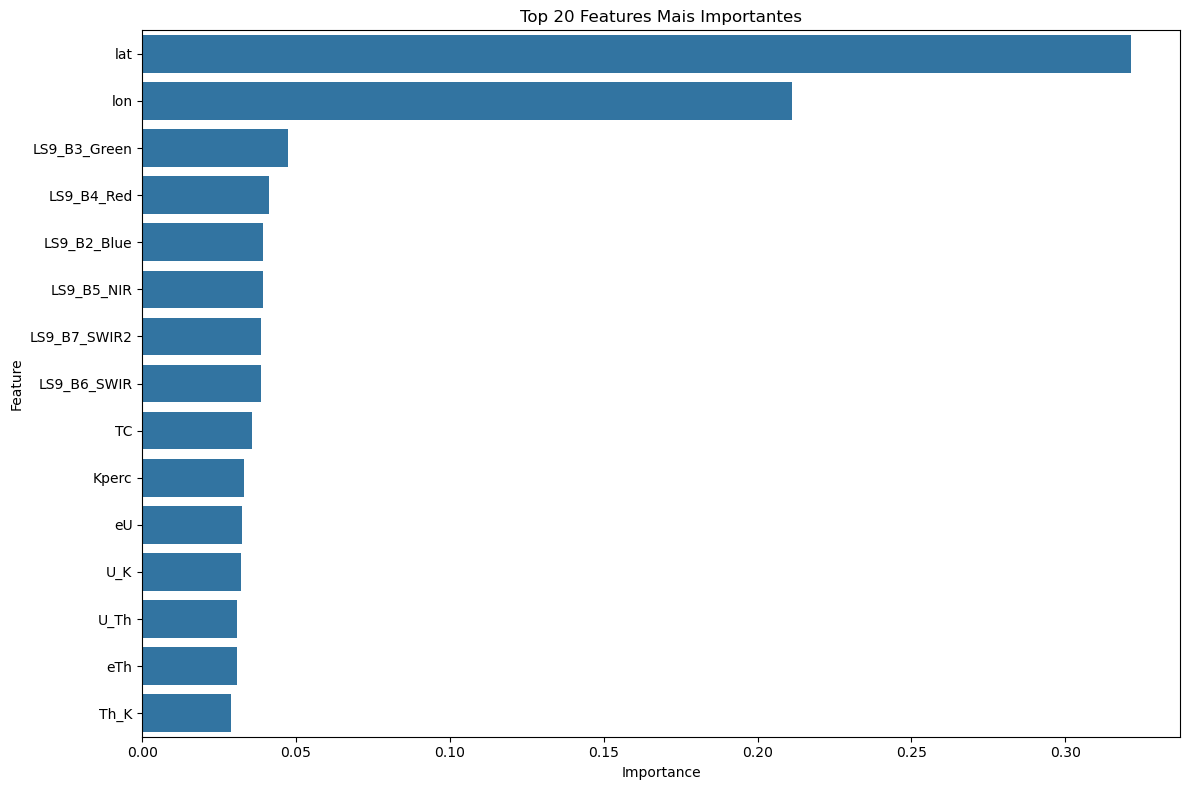

In [184]:
# Extrair importância das features
importances = best_rf.named_steps['classifier'].feature_importances_
features = X_train.columns
feature_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_imp = feature_imp.sort_values('Importance', ascending=False)

# Plotar top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
plt.title('Top 20 Features Mais Importantes')
plt.tight_layout()
plt.show()

# Salvar importância para análise
feature_imp.to_csv('feature_importance.csv', index=False)

In [ ]:
# Ajuste de thresholds por classe


thresholds = {}
for i, cls in enumerate(best_rf.classes_):
    precision, recall, thresh = precision_recall_curve(y_test == cls, y_proba[:, i])
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_idx = np.argmax(f1)
    thresholds[cls] = thresh[optimal_idx]

# Aplicar novos thresholds
y_pred_adj = np.array([best_rf.classes_[i] for i in np.argmax(
    y_proba > np.array([thresholds[cls] for cls in best_rf.classes_]), axis=1)])

print("\nRelatório com Thresholds Ajustados:\n", classification_report(y_test, y_pred_adj))


Relatório com Thresholds Ajustados:
                   precision    recall  f1-score   support

     MP1_beta_am       0.38      0.82      0.52       489
         NP12vpf       0.79      0.60      0.68      1236
NP3C_cortado_1vz       0.90      0.90      0.90       173
    NP3_alfa_avp       0.85      0.70      0.77        40
     NP3_beta_he       0.54      0.59      0.57       281
    NP3_gamma_ca       0.95      0.94      0.94       496
           NP3an       0.59      0.47      0.52       508
           NP3ps       0.95      0.87      0.91      1872

        accuracy                           0.75      5095
       macro avg       0.74      0.74      0.73      5095
    weighted avg       0.80      0.75      0.76      5095



NameError: name 'gdf' is not defined

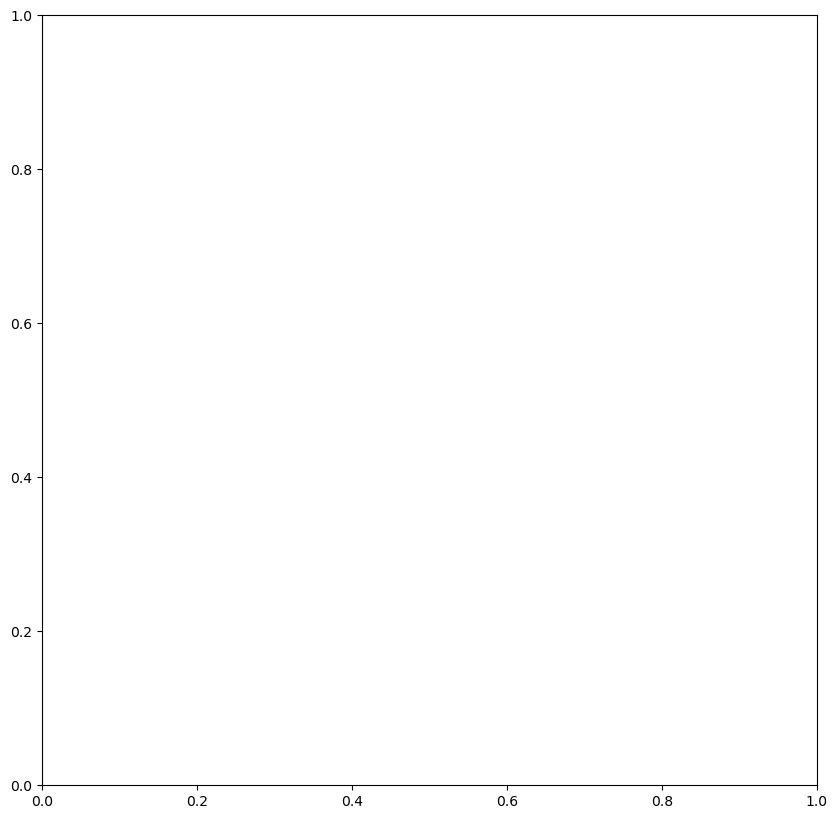

In [195]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='Prediction', categorical=True, legend=True, ax=ax, markersize=5)
plt.title('Mapa de Predição de Litologias')
plt.show()